In [1]:
import math

import pandas as pd

In [2]:
"""
Average colour values on the track (from collected data in the csvs):

Right sensor:
Red:
R - 810
G - 190
B - 140
Wood:
R - 900
G - 700
B - 320

Left sensor:
Red:
R - 750
G - 170
B - 140
Wood:
R - 800
G - 600
B - 300
"""

MAX_STEER = 100.0
MAX_LF_STEER = 1.0  # max fraction of MAX_STEER that it will do while line following

N = 100  # number of data points in normalized datasets

R_R_R = 730 # 810  # calibrated "red" values for right sensor
G_R_R = 170 # 190
B_R_R = 130 # 140

R_W_R = 1020 # 900  # calibrated "wood" values for right sensor
G_W_R = 930 # 700
B_W_R = 480 # 320

R_R_L = 760 # 750  # calibrated "red" values for left sensor
G_R_L = 170 # 170
B_R_L = 140 # 140

R_W_L = 1100 # 800  # calibrated "wood" values for left sensor
G_W_L = 950 # 600
B_W_L = 550 # 300

In [3]:
TRAIN_ITERATIONS = 200
TRAIN_STEP = 1.0
weights = [100.0, 100.0]
def lf_algorithm(weights, r_l, g_l, b_l, r_r, g_r, b_r):
    L_notred = abs(weights[0] * (g_l - G_R_L))
    R_notred = abs(weights[1] * (g_r - G_R_R))
    delta = L_notred - R_notred
    max_delta = max(abs(weights[0] * (G_W_L - G_R_L)), abs(weights[1] * (G_W_R - G_R_R)))
    delta_ratio = abs(delta / max_delta)
    # if delta_ratio < 0.01:
    #     delta_ratio = 0
    # else:
    #     delta_ratio = (math.log(delta_ratio / (1 - delta_ratio)) + 4.5) / 9
    steer = (MAX_STEER * MAX_LF_STEER) * delta_ratio
    if delta < -1:
        steer *= -1
    return steer

In [4]:
def lf_algorithm_steers(weights, l_df, r_df):
    steers = []
    for i in range(N):
        steers.append(
            lf_algorithm(
                weights,
                l_df.loc[i, "R"],
                l_df.loc[i, "G"],
                l_df.loc[i, "B"],
                r_df.loc[i, "R"],
                r_df.loc[i, "G"],
                r_df.loc[i, "B"],
            )
        )
    return steers

In [5]:
def input_data():
    r_r = []
    g_r = []
    b_r = []
    r_l = []
    g_l = []
    b_l = []

    for i in range(N):
        r_r.append(R_R_R + ((R_W_R - R_R_R) / (1 + math.exp(-1 * ((1 / 4) * i - 5)))))
        g_r.append(G_R_R + ((G_W_R - G_R_R) / (1 + math.exp(-1 * ((1 / 4) * i - 5)))))
        b_r.append(B_R_R + ((B_W_R - B_R_R) / (1 + math.exp(-1 * ((1 / 4) * i - 5)))))
        r_l.append(R_W_L + (-1 * (R_W_L - R_R_L) / (1 + math.exp(-1 * ((1 / 4) * i - 20)))))
        g_l.append(G_W_L + (-1 * (G_W_L - G_R_L) / (1 + math.exp(-1 * ((1 / 4) * i - 20)))))
        b_l.append(B_W_L + (-1 * (B_W_L - B_R_L) / (1 + math.exp(-1 * ((1 / 4) * i - 20)))))

    return [
        pd.DataFrame({"R": r_r, "G": g_r, "B": b_r}),
        pd.DataFrame({"R": r_l, "G": g_l, "B": b_l}),
    ]

In [6]:
def ideal_steer():
    steers = []
    for i in range(0, math.ceil(0.8 * (N / 2))):
        steers.append(
            (MAX_STEER * MAX_LF_STEER)
            * (math.floor(0.8 * (N / 2)) - i)
            / math.floor(0.8 * (N / 2))
        )
    for i in range(math.ceil(0.8 * (N / 2)), math.ceil(1.2 * (N / 2))):
        steers.append(0)
    for i in range(math.ceil(1.2 * (N / 2)), N):
        steers.append(
            -1
            * (MAX_STEER * MAX_LF_STEER)
            * (i - math.ceil(1.2 * (N / 2)))
            / (N - math.ceil(1.2 * (N / 2)))
        )
    steers.remove(0.0)
    steers.append(-100.0)
    return steers

In [7]:
def error(actual, ideal):
    total_e = 0.0
    for i in range(N):
        total_e += abs(actual[i] - ideal[i])
    return total_e / N

In [8]:
def calc_gradient(weights, l_df, r_df, linear):
    weights_copy = weights.copy()
    gradient = [0.0 for _ in range(len(weights))]
    for i in range(len(weights_copy)):
        # increase weight, calculate derror/dwi based on amount error changes
        e_before = error(lf_algorithm_steers(weights_copy, l_df, r_df), linear)
        weights_copy[i] += TRAIN_STEP
        e_after = error(lf_algorithm_steers(weights_copy, l_df, r_df), linear)
        weights_copy[i] -= TRAIN_STEP
        gradient[i] = ((e_before - e_after) / TRAIN_STEP)

        # if error increased, check if decreasing weight actually decreases error
        if gradient[i] < 0:
            e_before = error(lf_algorithm_steers(weights_copy, l_df, r_df), linear)
            weights_copy[i] -= TRAIN_STEP
            e_after = error(lf_algorithm_steers(weights_copy, l_df, r_df), linear)
            weights_copy[i] += TRAIN_STEP
            # if changing weight in either direction increases error, set gradient = 0
            if e_after > e_before:
                gradient[i] = 0
    return gradient

Weights before training: [100.0, 100.0]
Error before training: 9.420610650077998
Weights after training: [98.41394474756231, 101.58797990567962]
Error after training: 9.11000172665865


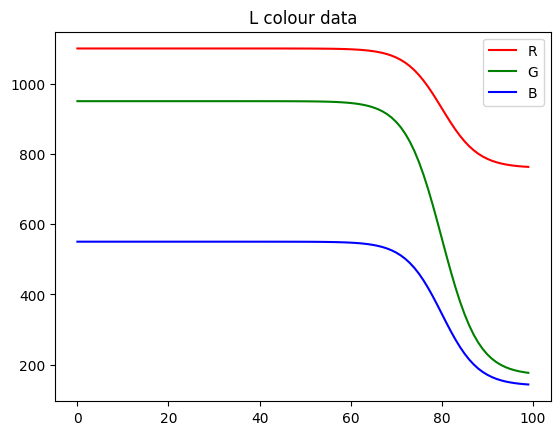

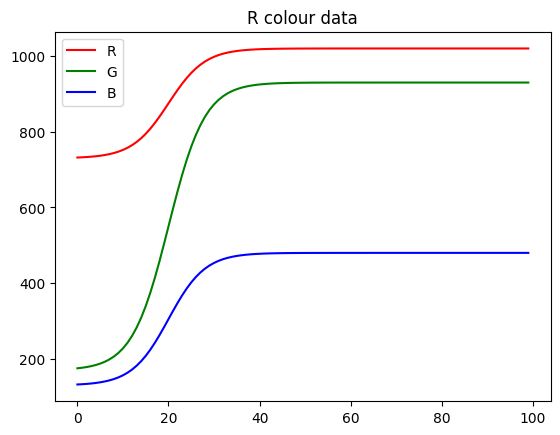

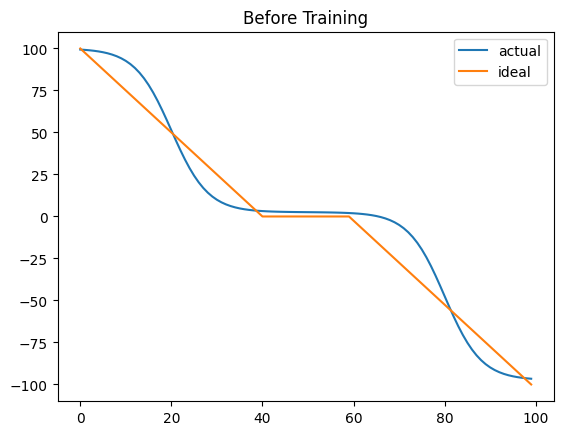

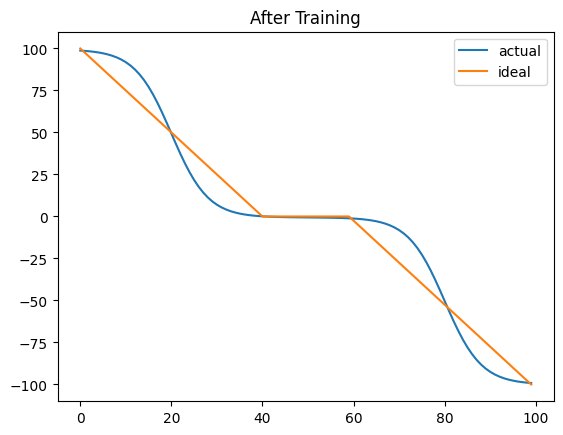

In [9]:
def train():
    dfs = input_data()
    l_df = dfs[1]
    r_df = dfs[0]
    plot_cols = ["r", "g", "b"]
    l_df.plot(title="L colour data", color=plot_cols)
    r_df.plot(title="R colour data", color=plot_cols)

    print(f"Weights before training: {weights}")

    steer_vals_untrained = lf_algorithm_steers(weights, l_df, r_df)
    ideal = ideal_steer()
    e = error(lf_algorithm_steers(weights, l_df, r_df), ideal)
    print(f"Error before training: {e}")
    plot_df = pd.DataFrame({"actual": steer_vals_untrained, "ideal": ideal})
    plot_df.plot(title="Before Training")

    for i in range(TRAIN_ITERATIONS):
        gradient = calc_gradient(weights, l_df, r_df, ideal)
        for j in range(len(weights)):
            weights[j] += gradient[j] * 10

    print(f"Weights after training: {weights}")
    e = error(lf_algorithm_steers(weights, l_df, r_df), ideal)
    print(f"Error after training: {e}")
    steer_vals_trained = lf_algorithm_steers(weights, l_df, r_df)
    plot_df = pd.DataFrame({"actual": steer_vals_trained, "ideal": ideal})
    plot_df.plot(title="After Training")


train()